In [37]:
import torch
import sys
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import copy, itertools
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
# Importing PyTorch specific modules.
from torch import Tensor
from torch.autograd import Variable
from torch.nn import Conv2d, Dropout, Linear, MaxPool2d, Module, ReLU, Sequential, Sigmoid
from torch.nn.utils import clip_grad_norm_
from torch.optim import AdamW
import torch.nn as nn
import seaborn as sns
from typing import Optional, Tuple
sys.path.append("..")
# Import Hopfield-specific modules.
from hflayers import HopfieldPooling

In [38]:
sys.path.append(r'./AttentionDeepMIL')

In [39]:
from dataloader import MnistBags
from model import Attention, GatedAttention

In [40]:
batch_size = 1
fold = 10
device = torch.device(r'cuda:1' if torch.cuda.is_available() else r'cpu')
num_epochs = 100

In [41]:
def get_data(file_path):
    df = pd.read_csv(file_path)
    df = pd.DataFrame(df)
    df = df[df.columns[0]]
    data_list = []    
    for i in range(0, df.shape[0]):  
        data = str(df.iloc[i]).split(' ')
        ids = data[0].split(':')
        idi = int(ids[0])
        idb = int(ids[1])
        idc = int(ids[2])
        data = data[1:]
        feature_vector = np.zeros(len(data))  
        for i, feature in enumerate(data):
            feature_data = feature.split(':')
            if len(feature_data) == 2:
                feature_vector[i] = feature_data[1]
        data_list.append([idi, idb, idc, feature_vector])
    return data_list

def get_bag(data, idb):
    data_array = np.array(data, dtype=object)
    bag_id = data_array[:, 1]
    return data_array[np.where(bag_id == idb)]

def cross_validation_set(in_list, fold, index):
    csv_list = copy.deepcopy(in_list)
    n = int(len(csv_list)/fold)
    chunked = [csv_list[i:i+n] for i in range(0, len(csv_list), n)]
    test_list = chunked.pop(index)
    return list(itertools.chain.from_iterable(chunked)), test_list

Prepare data

In [42]:
def prepare_data(dir, batch_size, fold):
    fox_data = get_data(dir)
    bag_ins_list = []
    num_bag = fox_data[-1][1]+1
    for i in range(num_bag):
        bag_data = get_bag(fox_data, i)
        bag_label = bag_data[0, 2]
        bag_vector = bag_data[:, 3]
        bag_ins_list.append([bag_label, bag_vector])
    bag_ins_list = shuffle(bag_ins_list, random_state=42)

    ### check both classes exist in testing bags
    valid_bags = 1
    while(valid_bags):
        bag_ins_list = shuffle(bag_ins_list, random_state=42)
        for k in range (0, fold):
            bags_list, test_list = cross_validation_set(bag_ins_list, fold=fold, index=k)
            bag_labels = 0
            for i, data in enumerate(test_list):
                bag_labels = np.clip(data[0], 0, 1) + bag_labels
            if bag_labels > 0:
                valid_bags = 0     
    
    data = bags_list
    data_test = test_list
    
    # Iterate through the data and convert arrays to tensors
    for i in range(len(data)):
        major_label, minor_arrays = data[i]
        for j in range(len(minor_arrays)):
            minor_arrays[j] = torch.from_numpy(np.array(minor_arrays[j], dtype=np.float32))
        data[i][1] = minor_arrays

    for i in range(len(data_test)):
        major_label, minor_arrays = data_test[i]
        for j in range(len(minor_arrays)):
            minor_arrays[j] = torch.from_numpy(np.array(minor_arrays[j], dtype=np.float32))
        data_test[i][1] = minor_arrays

    class CustomDataset(Dataset):
        def __init__(self, data):
            self.data = data

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            label, tensor_list = self.data[idx]
            concatenated_tensors = torch.stack(tensor_list.tolist(), dim=0).view(len(tensor_list), 1, len(tensor_list[0]), 1)
            label = bool(int(label) == 1)  # Convert 1 to True, -1 to False
            return concatenated_tensors, label

    # Create an instance of the custom dataset
    custom_dataset = CustomDataset(data)

    # Create a custom DataLoader
    dataloader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)

    # Create an instance of the custom dataset
    custom_dataset_test = CustomDataset(data_test)

    # Create a custom DataLoader
    dataloader_test = DataLoader(custom_dataset_test, batch_size=batch_size, shuffle=True)
    return dataloader, dataloader_test

In [43]:
def train_epoch(network: Module,
                optimizer: AdamW,
                data_loader: DataLoader
               ) -> Tuple[float, float, float]:
    """
    Execute one training epoch.
    
    :param network: network instance to train
    :param optimizer: optimizer instance responsible for updating network parameters
    :param data_loader: data loader instance providing training data
    :return: tuple comprising training loss, training error as well as accuracy
    """
    network.train()
    losses, errors, accuracies = [], [], []
    for data, target in data_loader:
        data, target = data.to(device=device), target[0].to(device=device)
        
        data = torch.squeeze(data, dim=-1)
        # Process data by Hopfield-based network.
        loss = network.calculate_objective(data, target)[0]

        # Update network parameters.
        optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(parameters=network.parameters(), max_norm=1.0, norm_type=2)
        optimizer.step()

        # Compute performance measures of current model.
        error, prediction = network.calculate_classification_error(data, target)
        accuracy = (prediction == target).to(dtype=torch.float32).mean()
        accuracies.append(accuracy.detach().item())
        errors.append(error)
        losses.append(loss.detach().item())
    
    # Report progress of training procedure.
    return sum(losses) / len(losses), sum(errors) / len(errors), sum(accuracies) / len(accuracies)


def eval_iter(network: Module,
              data_loader: DataLoader
             ) -> Tuple[float, float, float]:
    """
    Evaluate the current model.
    
    :param network: network instance to evaluate
    :param data_loader: data loader instance providing validation data
    :return: tuple comprising validation loss, validation error as well as accuracy
    """
    network.eval()
    with torch.no_grad():
        losses, errors, accuracies = [], [], []
        for data, target in data_loader:
            data, target = data.to(device=device), target[0].to(device=device)
            
            data = torch.squeeze(data, dim=-1)
            # Process data by Hopfield-based network.
            loss = network.calculate_objective(data, target)[0]

            # Compute performance measures of current model.
            error, prediction = network.calculate_classification_error(data, target)
            accuracy = (prediction == target).to(dtype=torch.float32).mean()
            accuracies.append(accuracy.detach().item())
            errors.append(error)
            losses.append(loss.detach().item())

        # Report progress of validation procedure.
        return sum(losses) / len(losses), sum(errors) / len(errors), sum(accuracies) / len(accuracies)

    
def operate(network: Module,
            optimizer: AdamW,
            scheduler: torch.optim.lr_scheduler.ExponentialLR,
            data_loader_train: DataLoader,
            data_loader_eval: DataLoader,
            num_epochs: int = 1
           ) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Train the specified network by gradient descent using backpropagation.
    
    :param network: network instance to train
    :param optimizer: optimizer instance responsible for updating network parameters
    :param data_loader_train: data loader instance providing training data
    :param data_loader_eval: data loader instance providing validation data
    :param num_epochs: amount of epochs to train
    :return: data frame comprising training as well as evaluation performance
    """
    losses, errors, accuracies = {r'train': [], r'eval': []}, {r'train': [], r'eval': []}, {r'train': [], r'eval': []}
    best_eval_accuracy = 0.0  # Initialize a variable to keep track of the best evaluation accuracy.
    patience = 20  # Define the number of epochs to wait for improvement before stopping.
    no_improvement_count = 0  # Initialize a counter to keep track of how many epochs have passed without improvement.

    best_eval_loss = float('inf')
    best_eval_error = float('inf')

    for epoch in range(num_epochs):
        # Train network.
        performance = train_epoch(network, optimizer, data_loader_train)
        scheduler.step()
        losses[r'train'].append(performance[0])
        errors[r'train'].append(performance[1])
        accuracies[r'train'].append(performance[2])

        # Evaluate current model.
        performance = eval_iter(network, data_loader_eval)
        losses[r'eval'].append(performance[0])
        errors[r'eval'].append(performance[1])
        accuracies[r'eval'].append(performance[2])

        # Check for improvement in evaluation accuracy.
        eval_accuracy = performance[2]
        if eval_accuracy > best_eval_accuracy:
            best_eval_accuracy = eval_accuracy
            best_eval_loss = performance[0]  # Record the corresponding loss.
            best_eval_error = performance[1]  # Record the corresponding error.

            no_improvement_count = 0
            # You may want to save the best model checkpoint here.
        else:
            no_improvement_count += 1

        # Check if early stopping criteria are met.
        if no_improvement_count >= patience:
            print(f"Early stopping after {epoch} epochs without improvement.")
            break
    
    # Report progress of training and validation procedures.
    return pd.DataFrame(losses), pd.DataFrame(errors), pd.DataFrame(accuracies), best_eval_loss, best_eval_error, best_eval_accuracy

In [44]:
def set_seed(seed: int = 42) -> None:
    """
    Set seed for all underlying (pseudo) random number sources.
    
    :param seed: seed to be used
    :return: None
    """
    torch.manual_seed(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def plot_performance(loss: pd.DataFrame,
                     error: pd.DataFrame,
                     accuracy: pd.DataFrame,
                    ) -> None:
    """
    Plot and save loss and accuracy.
    
    :param loss: loss to be plotted
    :param error: error to be plotted
    :param accuracy: accuracy to be plotted
    :param log_file: target file for storing the resulting plot
    :return: None
    """
    fig, ax = plt.subplots(1, 3, figsize=(20, 7))
    
    loss_plot = sns.lineplot(data=loss, ax=ax[0])
    loss_plot.set(xlabel=r'Epoch', ylabel=r'Loss')
    
    error_plot = sns.lineplot(data=error, ax=ax[1])
    error_plot.set(xlabel=r'Epoch', ylabel=r'Error')
    
    accuracy_plot = sns.lineplot(data=accuracy, ax=ax[2])
    accuracy_plot.set(xlabel=r'Epoch', ylabel=r'Accuracy')
    
    fig.tight_layout()
    plt.show(fig)

In [45]:
class HfPooling(Module):    
    def __init__(self, alpha, beta, input_dim, embedding_dims, layer_width, head_dimention, n_heads, hidden_size):
        """
        Initialize a new instance of a Hopfield-based pooling network.
        """
        super(HfPooling, self).__init__()
        # Fully connected linear embedding layers with ReLU activation
        self.embedding_layers = self.create_embedding_layers(input_dim, embedding_dims, layer_width, head_dimention)
        self.ReLu_blocks = self.create_embedding_layers(head_dimention, embedding_dims, hidden_size, hidden_size)
        # HopfieldPooling layer
        self.hopfield_pooling = HopfieldPooling(
            input_size=head_dimention, output_size=head_dimention, num_heads=n_heads, alpha = alpha, scaling = beta, hidden_size= 32, dropout=0.75) 
        
        
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )

        self.dp = Dropout(
            p=0.1
        )

    def create_embedding_layers(self, input_dim, embedding_dims, layer_width, head_dimention):
        layers = []
        for i in range(embedding_dims + 1):
            
            if i == 0:
                layers.append(nn.Linear(input_dim, layer_width))
            elif i == embedding_dims:
                layers.append(nn.Linear(layer_width, head_dimention))
            else:
                layers.append(nn.Linear(layer_width, layer_width))
            layers.append(nn.ReLU())
        return nn.Sequential(*layers)
        
    def forward(self, input: Tensor) -> Tuple[Tensor, Tensor, Optional[Tensor]]:
        """
        Compute result of Hopfield-based pooling network on specified data.
        
        :param input: data to be processed by the Hopfield-based pooling network
        :return: result as computed by the Hopfield-based pooling network
        """

        x = input.squeeze(0).squeeze(-1)
        x = self.embedding_layers(x)
        x = x.unsqueeze(0).squeeze(2)
        x = self.hopfield_pooling(x)
        x = x.squeeze(0)
        x = self.ReLu_blocks(x)
        x = self.dp(x)
        x = self.classifier(x)

        Y_hat = torch.ge(x, 0.5).float()

        return x, Y_hat, None

    def calculate_classification_error(self, input: Tensor, target: Tensor) -> Tuple[Tensor, Tensor]:
            """
            Compute classification error of current model.
            
            :param input: data to be processed by the Hopfield-based pooling network
            :param target: target to be used to compute the classification error of the current model
            :return: classification error as well as predicted class
            """
            Y = target.float()
            _, Y_hat, _ = self.forward(input)
            error = 1.0 - Y_hat.eq(Y).cpu().float().mean().item()
            return error, Y_hat

    def calculate_objective(self, input: Tensor, target: Tensor) -> Tuple[Tensor, Optional[Tensor]]:
        """
        Compute objective of the current model
        
        :param input: data to be processed by the Hopfield-based pooling network
        :param target: target to be used to compute the objective of the current model
        :return: objective as well as dummy A (see accompanying paper for more information)
        """
        Y = target.float().view(1)
        Y_prob, _, A = self.forward(input)
        Y_prob = torch.clamp(Y_prob, min=1e-5, max=(1.0 - 1e-5))
        neg_log_likelihood = -1.0 * (Y * torch.log(Y_prob) + (1.0 - Y) * torch.log(1.0 - Y_prob))

        return neg_log_likelihood, A

In [46]:
dataloader_train, dataloader_eval = prepare_data('../datasets/Tiger/data_100x100.svm', batch_size, fold)

In [47]:
set_seed()
betas = tensor = torch.full((16,), 10).to(device)
network = HfPooling(alpha=1.0, beta=betas, input_dim=231, embedding_dims=1, layer_width=128, head_dimention=32, n_heads=16, hidden_size=128).to(device=device)
optimizer = AdamW(params=network.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.94)

In [48]:
losses, errors, accuracies, min_loss, min_error, max_accuracy = operate(
    network=network,
    optimizer=optimizer,
    scheduler = scheduler,
    data_loader_train=dataloader_train,
    data_loader_eval=dataloader_eval,
    num_epochs=num_epochs)

print(f"Loss: {min_loss:.5f}")
print(f"Error: {min_error:.5f}")
print(f"Accuracy: {max_accuracy:.5f}")

Early stopping after 21 epochs without improvement.
Loss: 0.77067
Error: 0.10000
Accuracy: 0.90000


In [49]:
set_seed()
betas = tensor = torch.full((16,), 10).to(device)
network = HfPooling(alpha=1.5, beta=betas, input_dim=231, embedding_dims=1, layer_width=128, head_dimention=32, n_heads=16, hidden_size=128).to(device=device)
optimizer = AdamW(params=network.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.94)

In [50]:
losses, errors, accuracies, min_loss, min_error, max_accuracy = operate(
    network=network,
    optimizer=optimizer,
    scheduler = scheduler,
    data_loader_train=dataloader_train,
    data_loader_eval=dataloader_eval,
    num_epochs=num_epochs)

print(f"Loss: {min_loss:.5f}")
print(f"Error: {min_error:.5f}")
print(f"Accuracy: {max_accuracy:.5f}")

Early stopping after 20 epochs without improvement.
Loss: 0.64978
Error: 0.05000
Accuracy: 0.95000


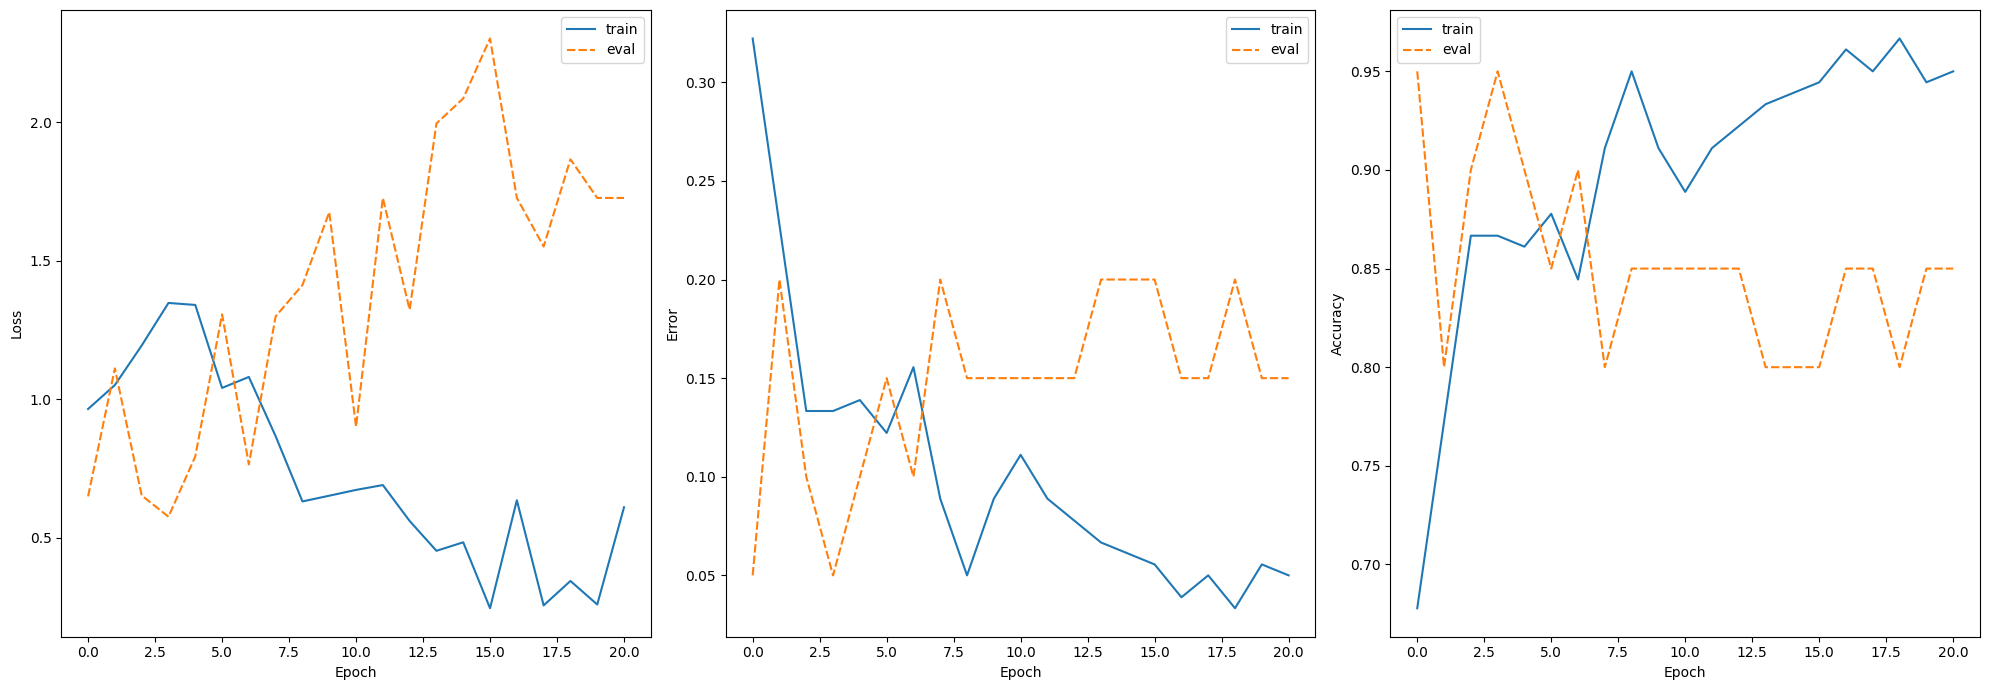

In [51]:
plot_performance(loss=losses, error=errors, accuracy=accuracies)

In [52]:
set_seed()
betas = tensor = torch.full((16,), 10).to(device)
network = HfPooling(alpha=2.0, beta=betas, input_dim=231, embedding_dims=1, layer_width=128, head_dimention=32, n_heads=16, hidden_size=128).to(device=device)
optimizer = AdamW(params=network.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.94)

In [53]:
losses, errors, accuracies, min_loss, min_error, max_accuracy = operate(
    network=network,
    optimizer=optimizer,
    scheduler = scheduler,
    data_loader_train=dataloader_train,
    data_loader_eval=dataloader_eval,
    num_epochs=num_epochs)

print(f"Loss: {min_loss:.5f}")
print(f"Error: {min_error:.5f}")
print(f"Accuracy: {max_accuracy:.5f}")

Early stopping after 23 epochs without improvement.
Loss: 1.13614
Error: 0.20000
Accuracy: 0.80000


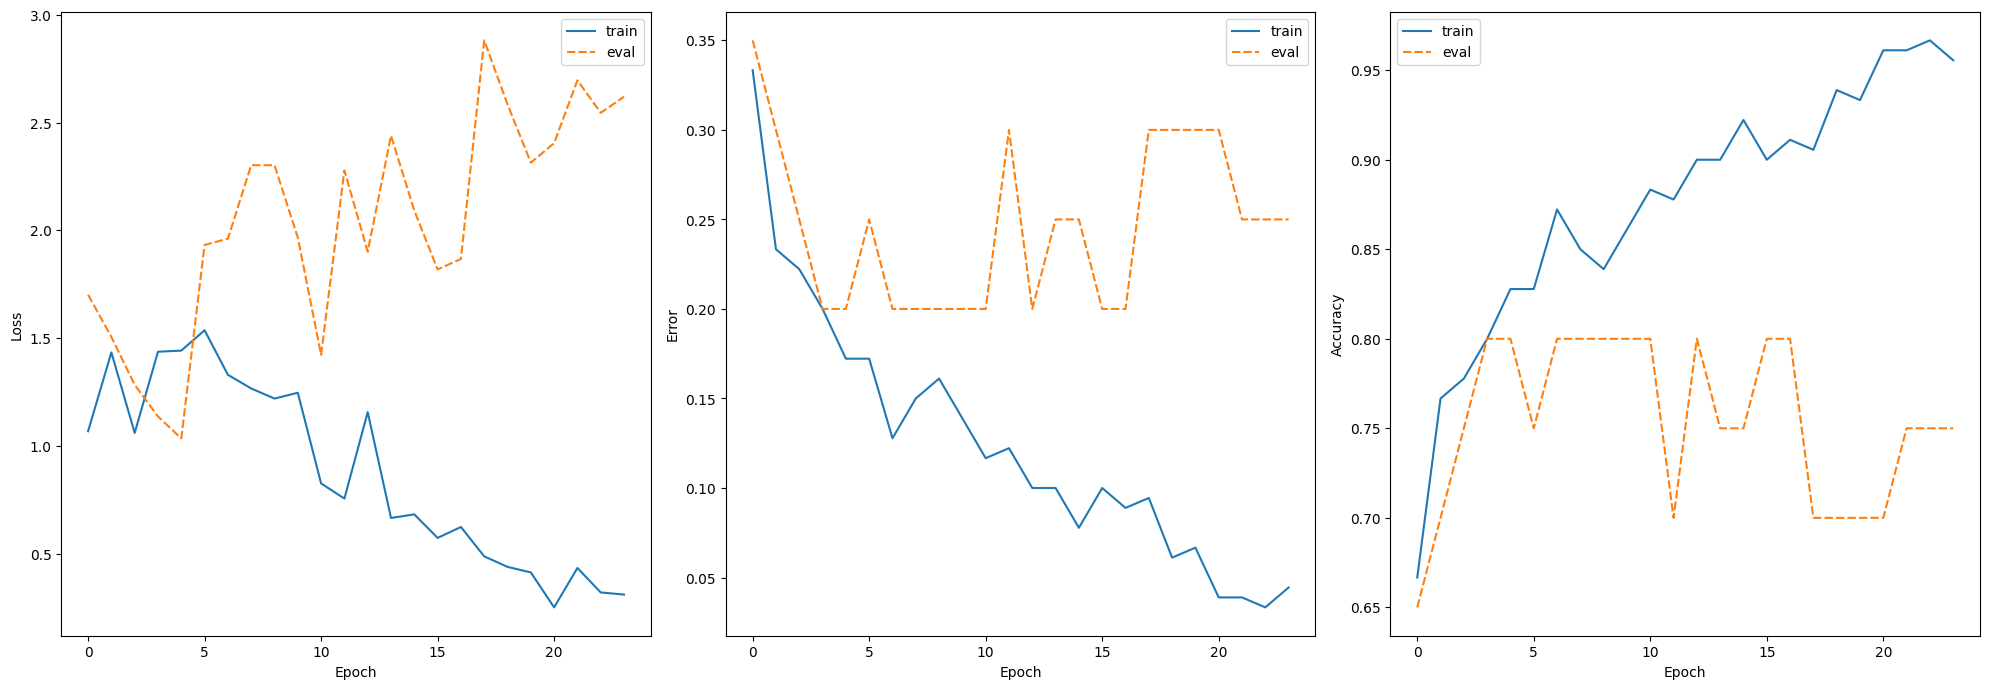

: 

In [54]:
plot_performance(loss=losses, error=errors, accuracy=accuracies)